In [1]:
import random
import numpy as np
from IPython.core.display import display, HTML
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
from matplotlib import pylab as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
# setup disply parameters
float_formatter = StrMethodFormatter("{x:0.03f}")
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size|
plt.rc("animation", html="html5")
pd.set_option("display.max_rows", 500)
np.random.seed(100)
random.seed(100)

/var/folders/51/d42424vj0jn8ntjscwsld_x40000gn/T/ipykernel_27397/2738127493.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Developing an agent for SCML2024 (Standard)

In 2024, we introduced a new implementation of the SCML-Standard track which simplified its API making it exactly the same as the simpler SCML-OneShot track. The older version of the game is not supported anymore.

**SCML-Std brief introduction** Please refer to the first tutorial for a brief introduction about the world simulated in this game as well as pointers to more information. We will assume knowledge of at least this brief introduction in the remainder of this tutorial.

The main differences between the Standard and OneShot simulation that will affect this tutorial are the following:

1. Agents can negotiate **future contracts** instead of only being allowed to negotiate about deliveries on the same day. This means that we better consider future contracts when negotiating instead of trying to secure all of our needs on the day they arise.
2. Negotiated **prices have a larger range** which necessitates reasoning about prices as well as quantity matching. This means that we should be careful about accepting good prices (i.e. low prices when buying and high prices when selling).
3. Production graphs can be **deeper** which means that some agents will negotiate with **both** their suppliers and consumers at the same time. This means that our agent may find itself in the **middle** of the production graph with no exogenous contracts. In such cases, the agent may set some target production level and try to achieve it instead of relying on its exogenous contracts to set its targets.


First things first, let's create some helper functions that will allow us to evaluate different agents we develop in this tutorial.

Here we use the `WorldRunner` class which is designed to allow us to compare multiple agents in **exactly** the same conditions. To create a `WorldRunner`, you need to pass a context which is used for generating the worlds in which the agents are evaluated. the SCML package defines several contexts that allow us to control these worlds. For example the `StrongSupplierContext` will always create worlds in which the agent being evaluated is in the first production level $L_0$ with more agents on this level than on the next level. You cand define your own contexts for experimenting with specific conditions (e.g. specific exogenous contract distribution, market structure, etc). The most general context which will produce any world that your agent may encounter in the [ANAC comptition](https://scml.cs.brown.edu) is the `ANACOneShotContext` for one-shot worlds and `ANACStdContext` for standard worlds.

We create two runners:

1. **single_agent_runner** in which a single agent is being evaluated while the rest of the agents are sampled randomly from a subset of SCML built-in agents.
2. **full_market_runner** in which *all* agents in the market are controlled by the agent type being evaluated. This may be helpful in understanding how your agent behaves in this extreme condition but can be misleading as an estimate of the agent's performance in the official ANAC competition.

<div style="word-wrap: break-word; word-break: break-all; background-color:#98F1ED;">
<i>We are using a relatively large nubmer of configurations, repetitions per configuration and steps (days) per repetition. If you are running this notebook for the first time, consider reducing CONFIGS, REPS, STEPS above to make it run faster</i>.
   </div>

This is time to describe some of the tools that the `WorldRunner` gives you to evaluate the agent. The `WorldRunner` is a Callable. You just call it with the class (agent type) you want to evaluate. You can optionally pass parameters if you would like to compared different parameters for example. Remember in this case to also pass a name to differentiate between different parameter choices.

In [2]:
import pandas as pd
import math
from typing import Iterable
from rich.jupyter import print

from negmas import SAOResponse, ResponseType, Outcome, SAOState
from scml.std import *
from scml.runner import WorldRunner

In [3]:
# create a runner that encapsulates a number of configs to evaluate agents
# in the same conditions every time
CONFIGS, REPS, STEPS = 10, 3, 50
context = ANACStdContext(
    n_steps=STEPS, n_processes=3, world_params=dict(construct_graphs=True)
)
single_agent_runner = WorldRunner(
    context, n_configs=CONFIGS, n_repetitions=REPS, save_worlds=True
)
full_market_runner = WorldRunner.from_runner(
    single_agent_runner, control_all_agents=True
)

### Testing a completely random agent

Let's try an agent that behaves randomly:

In [4]:
full_market_runner(RandomStdAgent);

We can use the runner now to display the worlds for a given type that we evaluated:

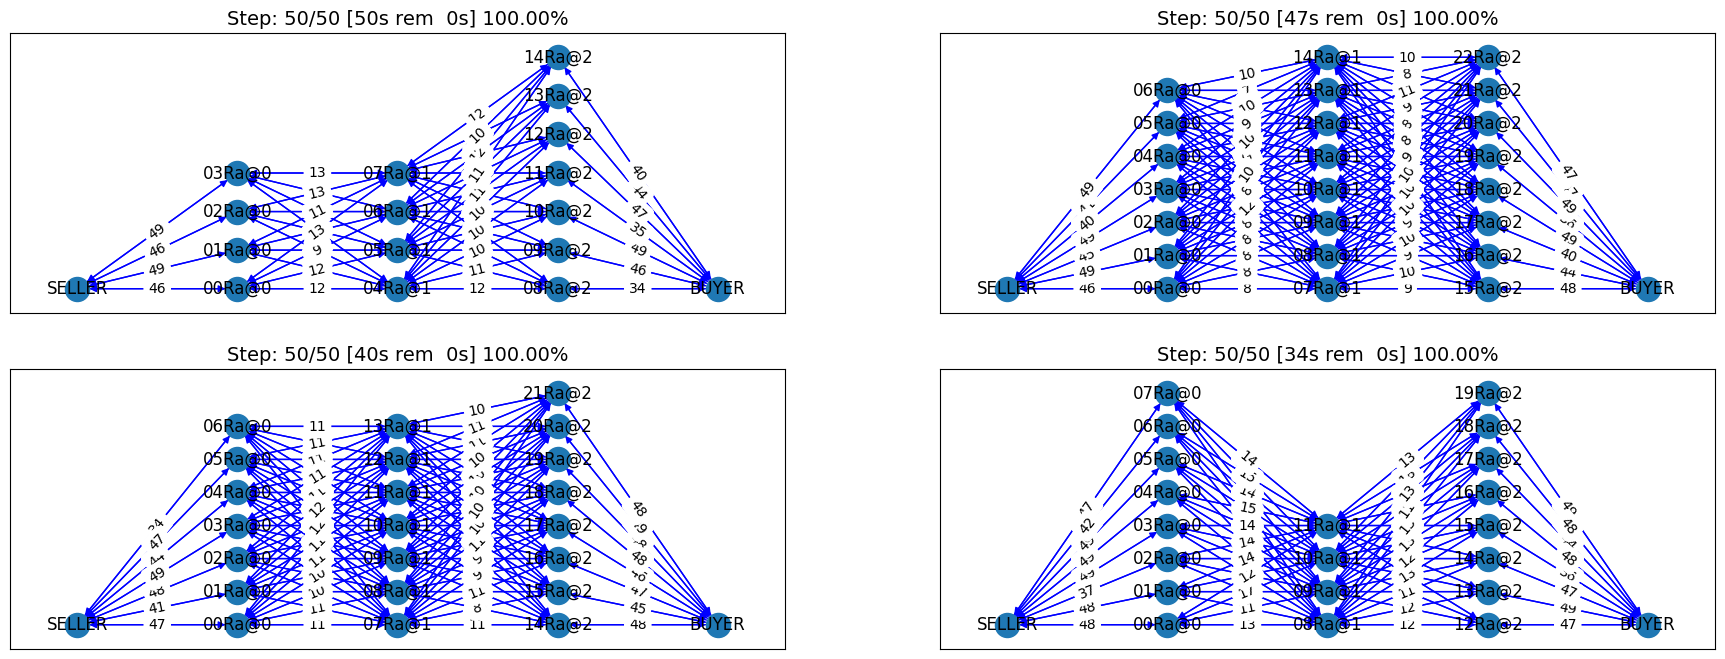

In [5]:
full_market_runner.draw_worlds_of(RandomStdAgent);

Lots of contracts have been reached, but were they good contracts?
We can use the runner now to plot several statistics (e.g. shortfall-penalty, disposal-cost, productivity, and score in this example). There are more than 42 such statistics that you can display.

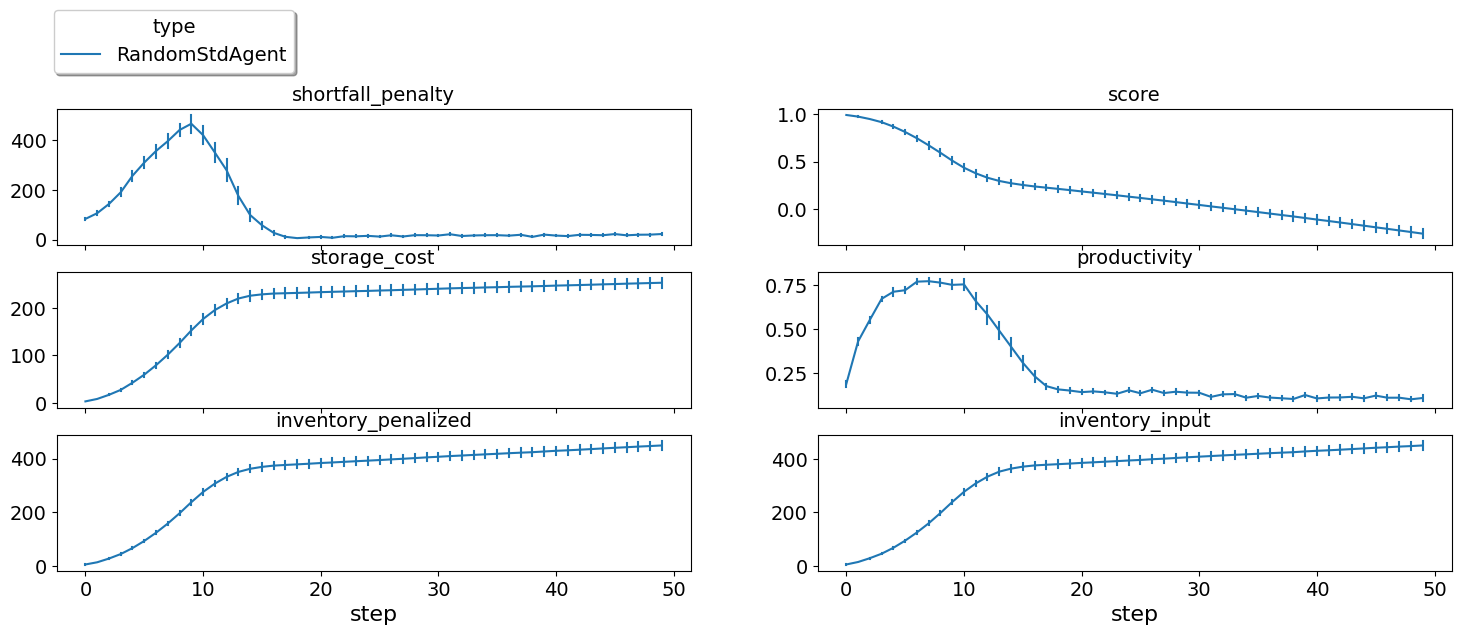

In [6]:
full_market_runner.plot_stats(agg=False);

The score is going down *monotonically* showing that this random agent is losing money every step. It is clear that the agent gets too high shortfall penalty and storage cost. The `inventory_input` plot shows the amount of the input product in the inventory at the end of each simulation step. It is clear that the agent accomulates too much of this product as it cannot sell it when it is in the first production level and seems to buy too much when it is in the last production level.

This score is much lower than what we got in the oneshot world. Some of the reasons for that are the following:

1. In the standard game, the range of prices is large enough that price matters. Choosing a random price is not a good idea here. In the oneshot game, on the other hand, price range was extremely small that the price did not really matter.
2. In the oneshot game, all negotiations happen about deliveries on the same day and products are perishable so you do not accomulate stock over time. In the standard game, on the other hand, negotiations are about deliveries on the same day or  the future. Picking randomly from those will reduce the probability of picking what you need today and increase the probability of picking something you do not really need in the future.

Now we are ready to develop a do-nothing agent, but first, let's try some of the built in agents to see how do they behave.

In [7]:
full_market_runner(SyncRandomStdAgent)
full_market_runner(GreedyStdAgent);

We can also add a couple of one-shot agents in the mix

In [8]:
from scml.oneshot.agents import *

full_market_runner(RandomOneShotAgent)
full_market_runner(GreedyOneShotAgent)
full_market_runner(RandDistOneShotAgent)
full_market_runner(EqualDistOneShotAgent);

and look at the final results:

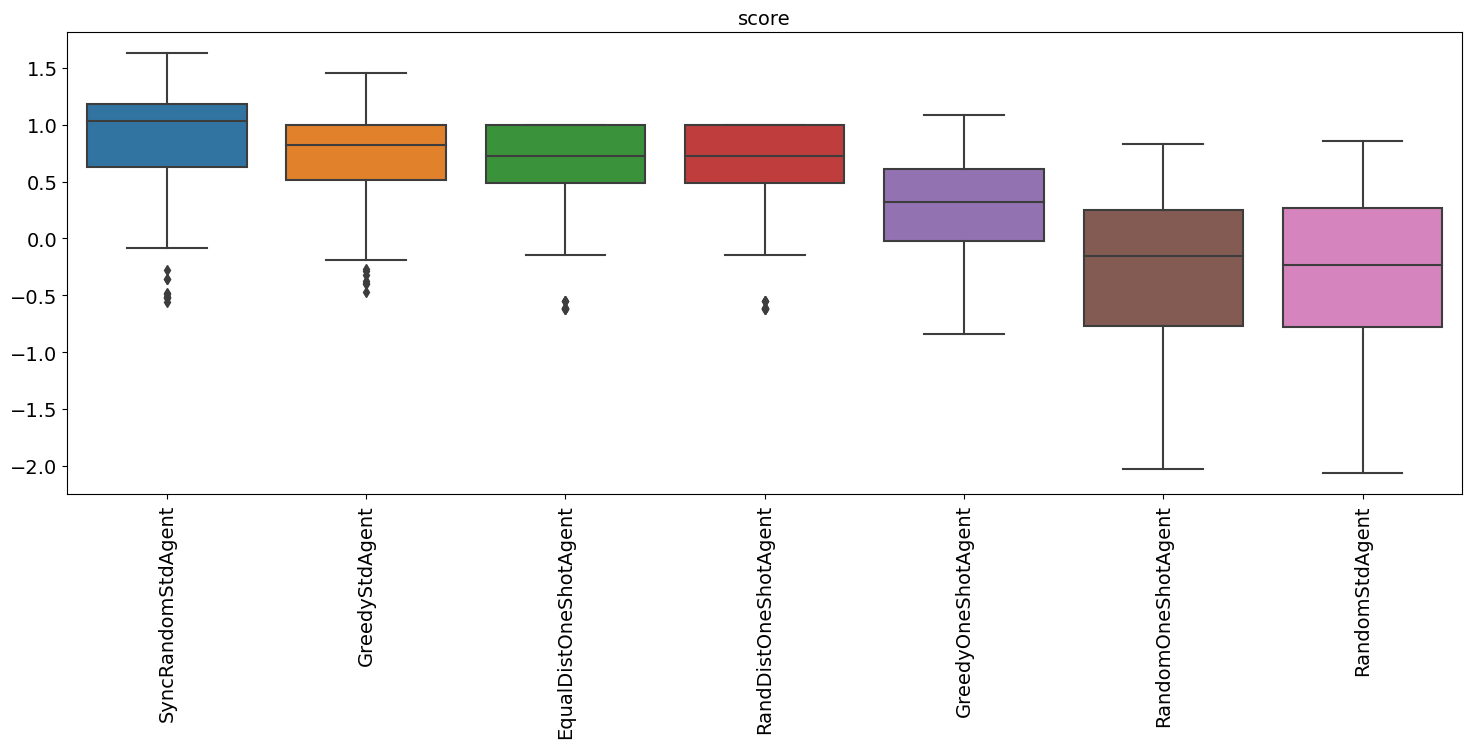

In [9]:
full_market_runner.plot_stats(stats="score");

The two builtin agents behaved roughly similarliy and outperformed all one-shot agents even though the random std agent is even worse than the random one-shot agent (because it samples from a much larger outcome space). 

Note that this test was when the agent controller *every* factory in the market. This is very different than the ANAC competition in whic the agent controls a single agent. Luckily, we already have a runner that tests exactly this case. Let's see how does `RandomStdAgent` behave in such cases:

In [10]:
single_agent_runner(RandomStdAgent);

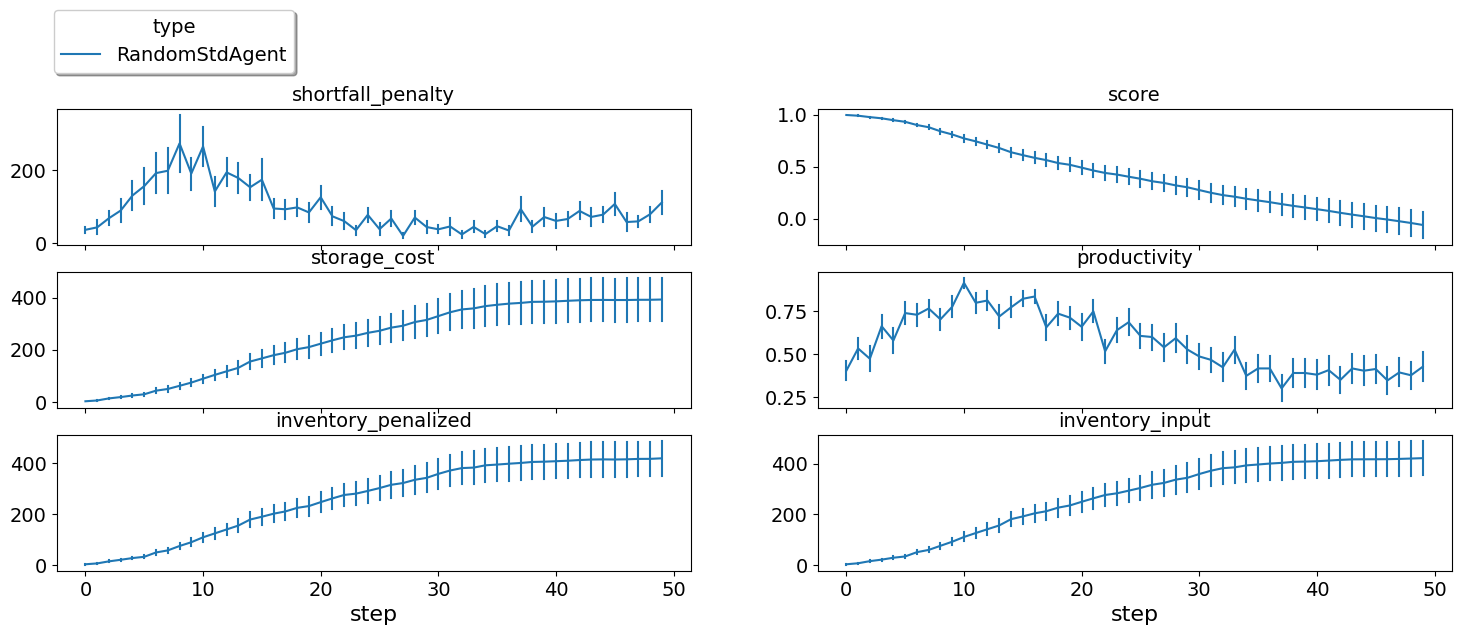

In [11]:
single_agent_runner.plot_stats(agg=False);

Still losing money at the same level. The fact that other agents made sense did not help our random agent get higher score. This is very different from the one-shot case (if you have already checked the previous tutorial).
We can now check the distribution of scores for our agent using the `score_summary` method:

In [12]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
0,RandomStdAgent,-0.061693,30.0,-0.061693,0.708594,-1.504509,-0.510917,-0.183504,0.474423,0.981504


Now, we are ready to start working on our agent.

### A do-nothing agent

In [13]:
class MyStdDoNothing(StdPolicy):
    """My Agent that does nothing"""

    def act(self, state):
        return {}

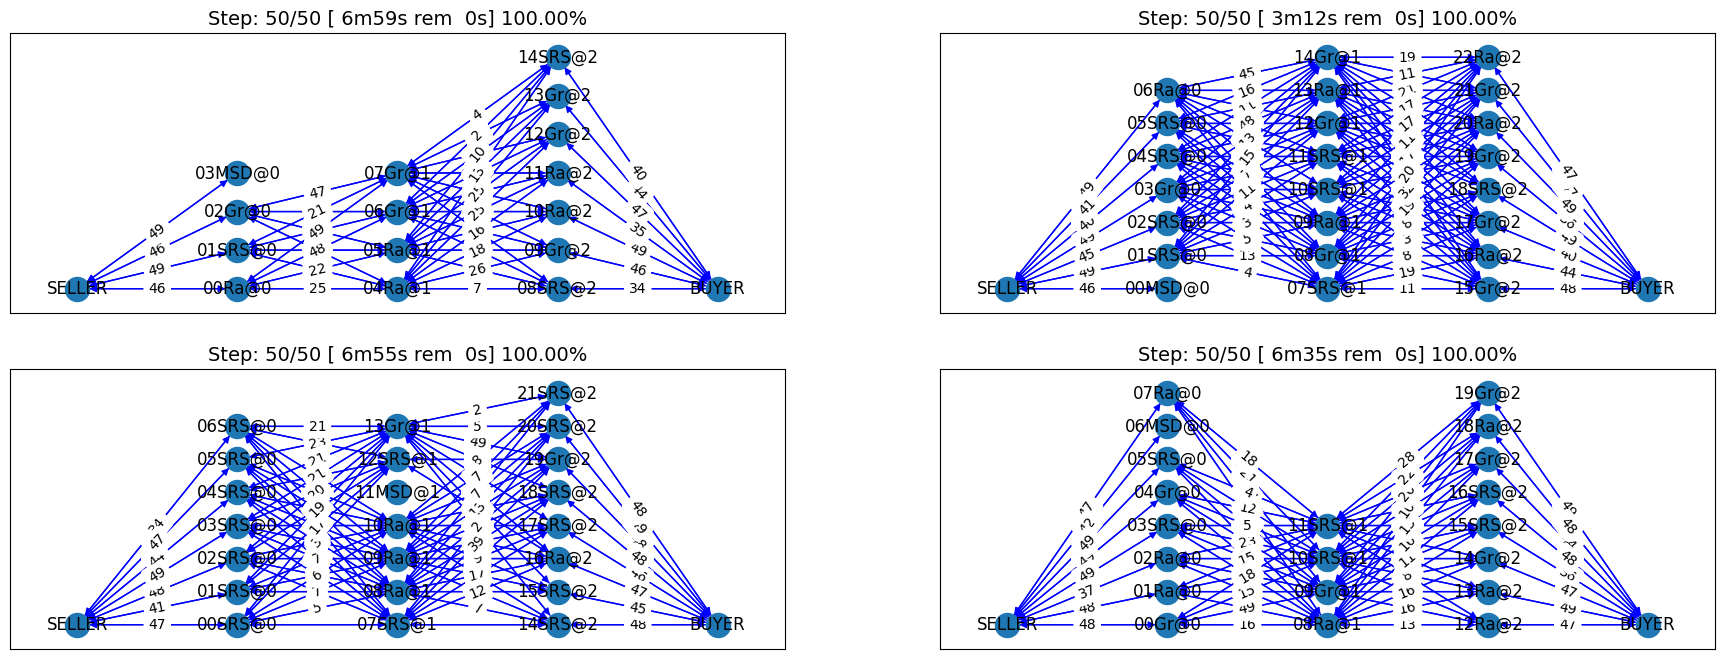

In [14]:
single_agent_runner(MyStdDoNothing)
single_agent_runner.draw_worlds_of(MyStdDoNothing);

In all of the graph representing world simulations, we use short names that represent the type of the agent. For example an agent named `01Gr@0` is an agent of type `GreedyStdAgent` at production level 1 that was the third agent to create. `MSD` here is a shorthand for `MyStdDoNothingAgent`.

Looking at the `contracts-signed`, we can see that none of the concluded contracts involved our do-nothing agent. Nevertheless, these agents still had *exogenous contracts* which means that they will lose money. A do-nothing agent will usually lose money in this game.

Let's check the scores of different agents to confirm:

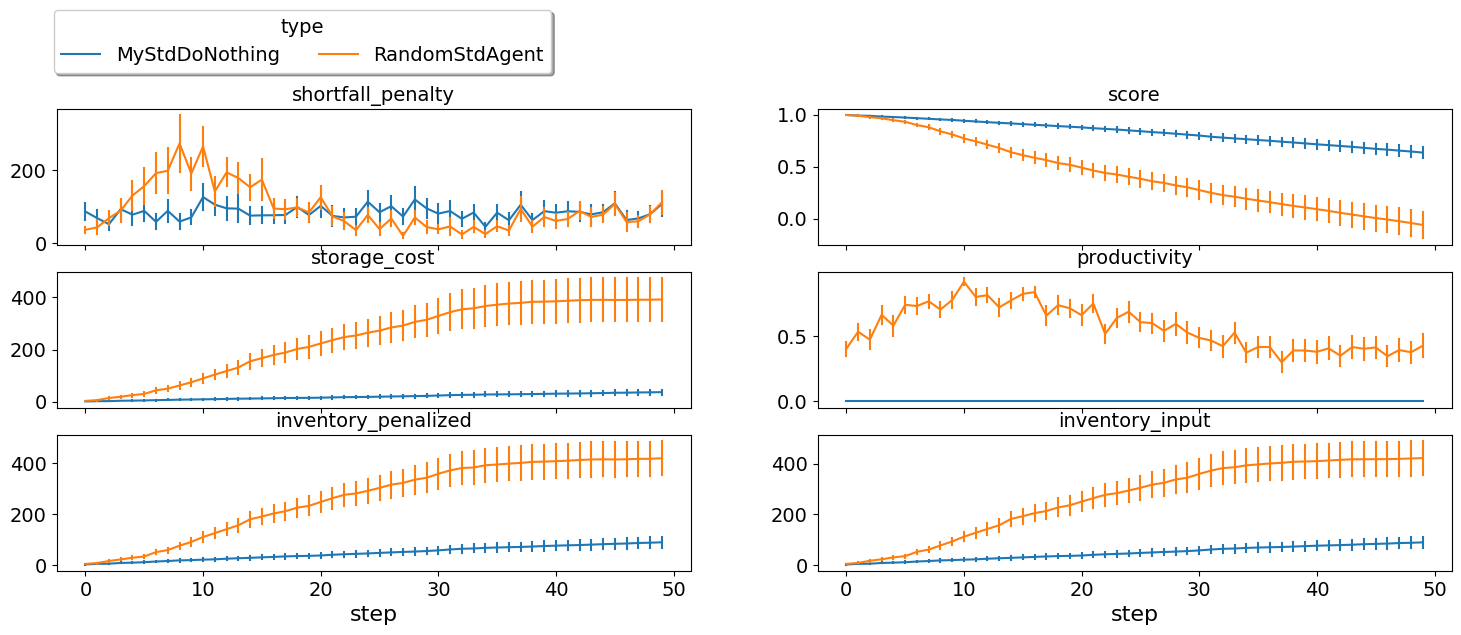

In [15]:
single_agent_runner.plot_stats(agg=False);

Our do-nothing agent can never makes money. That is because it cannot get any contracts from negotiation to satisfy its needs from the exogenous contracts but it still have to pay for disposal cost and shortfall penalties when it is in the first or last production levels. Nevertheless, it is *better* than behaving randomly in a clear inversion of the situation in the SCML oneshot game. One reason is that the outcome space is too large now that behaving randomly is almost never going to get you good contracts (no contracts will be better). Another reason is that agents in the middle of the production graph are better of not trading at all than if they acrue any imbalance between their sales and supplies which is highly likely if they behave randomly.

In [16]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
0,MyStdDoNothing,0.634120,30.0,0.634120,0.303902,0.123079,0.504789,0.704111,0.878543,1.000000
1,RandomStdAgent,-0.061693,30.0,-0.061693,0.708594,-1.504509,-0.510917,-0.183504,0.474423,0.981504


We can also have a look at the *exogenous* contracts that drive the market.

In [17]:
def analyze_contracts(worlds, exogenous_only=True):
    """
    Analyzes the contracts signed in the given world
    """
    dfs = []
    for world in worlds:
        dfs.append(pd.DataFrame.from_records(world.saved_contracts))
    data = pd.concat(dfs)
    if exogenous_only:
        data = data.loc[
            (data["seller_name"] == "SELLER") | (data["buyer_name"] == "BUYER"), :
        ]
    return data.groupby(["seller_name", "buyer_name"])[["quantity", "unit_price"]].agg(
        dict(quantity=("sum", "count"), unit_price="mean")
    )


analyze_contracts(single_agent_runner.worlds_of())

quantity       unit_price
                            sum count       mean
seller_name buyer_name                          
08SRS@2     BUYER           582   210  44.285714
09Gr@2      BUYER          1092   282  44.340426
10Ra@2      BUYER          1536   300  44.840000
10SRS@2     BUYER          2928   300  48.800000
11MSD@2     BUYER          1143   150  46.360000
11Ra@2      BUYER          1635   360  46.800000
12Gr@2      BUYER          4158   846  44.843972
12Ra@2      BUYER          2808   588  45.948980
12SRS@2     BUYER          2988   300  33.380000
13Gr@2      BUYER          6270   864  43.750000
13Ra@2      BUYER          7752  1188  43.156566
14Gr@2      BUYER          1206   288  44.666667
14MSD@2     BUYER          1527   150  45.780000
14Ra@2      BUYER          8979  1050  41.928571
14SRS@2     BUYER          2052   540  45.722222
15Gr@2      BUYER          1710   294  45.959184
15MSD@2     BUYER          1416   150  44.040000
15Ra@2      BUYER          9714  1338  42.439462
15SRS@2     BUYER          1878   492  47.243902
16MSD@2     BUYER           744   141  45.340426
16Ra@2      BUYER          6216   999  45.468468
16SRS@2     BUYER          1194   294  47.489796
17Gr@2      BUYER          3666   816  45.294118
17Ra@2      BUYER          2484   300  46.260000
17SRS@2     BUYER          1272   282  46.234043
18Ra@2      BUYER          2616   576  44.447917
18SRS@2     BUYER          3114   594  46.525253
19Gr@2      BUYER          4224   816  45.977941
19SRS@2     BUYER          2046   300  42.620000
20Ra@2      BUYER          2238   300  48.420000
20SRS@2     BUYER          3912   594  44.636364
21Gr@2      BUYER          1500   288  47.312500
21SRS@2     BUYER          2190   546  44.681319
22Ra@2      BUYER          2034   288  46.208333
22SRS@2     BUYER          2142   294  42.204082
SELLER      00Gr@0         5334   852  10.190141
            00MSD@0         840   141  10.191489
            00Ra@0         3084   681  10.207048
            00SRS@0        5160  1014  10.112426
            01Gr@0         2808   300   9.920000
            01Ra@0         5532   864  10.118056
            01SRS@0       10386  1662  10.119134
            02Gr@0        12000  1476  10.060976
            02Ra@0          672   228   9.763158
            02SRS@0        8580  1146   9.790576
            03Gr@0         6228   870   9.813793
            03MSD@0         894   150  10.120000
            03Ra@0         4422   672   9.937500
            03SRS@0        9336  1164   9.881443
            04Gr@0         2526   300  10.000000
            04MSD@0         417   105   9.742857
            04Ra@0         4401   903  10.156146
            04SRS@0        6888  1074   9.944134
            05Gr@0         1890   288  10.104167
            05Ra@0         4770   522   9.919540
            05SRS@0       10926  1368  10.118421
            06Gr@0         5238   846  10.021277
            06MSD@0         507   129   9.883721
            06Ra@0         2595   429   9.993007
            06SRS@0        2382   498   9.975904
            07Gr@0         1800   288  10.020833
            07Ra@0         1506   288  10.354167
            07SRS@0        1692   270  10.088889

There are few things to note about the distribution of the *exogenous* contracts:

- The unit price of the raw material is always lower than that of the final product. This is the source of profitability in this market.
- Each agent has a different mean and standar deviation for the quantities in its exogenous contracts. This means that different agents will have different utility functions but these utility functions for different steps are related because the exogenous contract is sampled from some common distribution for each agent for all the steps which makes learning more useful in the game.

### Building your own agent

A standard agent needs only to do negotiation. The simplest possible version (`MyDoNothingAgent` above) just responded to offers from its partners and proposed new offers to them.

#### Your AWI

As described in a [previous tutorial](https://scml.readthedocs.io/en/latest/tutorials/01.run_scml2020.html), your agent can sense and act in the simulation by accessing methods and properties of its AWI which is accessible at any time as:

```python
self.awi
```

You can see all of these methods and properties specific for the **StdAWI** and its descendents [here](https://scml.readthedocs.io/en/latest/api/scml.std.StdAWI.html).

#### Your ufun

The Std game has the advantage that it is possible at the end of each simulation step (day) to calculate **exactly** the profit you will be getting for the set of contracts you have (either through negotiation or as exogenous contracts). We provide a utility function class ([StdUtilityFunction](https://scml.readthedocs.io/en/latest/api/scml.std.StdUFun.html) which can be used normally as any NegMAS [UtilityFunction](http://www.yasserm.com/negmas/api/negmas.preferences.UtilityFunction.html). This ufun is available to your all the time (a new one is created for each simulation step) and is accessible as:

```python
self.ufun
```

The most important services this ufun class provides for you are the following:

- `from_offers`: This method receives a list of outcomes and a list of booleans indicating whether each of them is for buying or for selling. It returns to you the profit you will get if all of these outcomes _and nothing else_ became contracts. An outcome is just a tuple (quantity, delivery time, unit price). You can use this callback during negotiation to judge hypothetical agreements with your partners. **Note that only offers to be delivered today will be considered**
- `from_contracts`: This method is the same as `from_offers` but it receives a list of `Contract` objects. It is useful after all negotiations are finished to calculate the profit you will be getting for this step. **Note that only contracts to be delivered today will be considered**
- `is_breach`: will tell you whether or not getting the given total input and output quantities will make you cause a breach. Notice that breaches are expected in the Standard track as any mismatch in the quantities of inputs and outputs will constitute a breach.
- `breach_level`: returns a value between zero and one specifying the level of breach that will be recorded for a given total input and output quantities.
- `find_limit`: finds either the maximum or the minimum possible profit (minimum profit is maximum loss) attainable in the current simulation step (day). This is useful when you want to normalize utility values between zero and one. Two of the agents we will develop during this tutorial will use this feature.
- `max_utility`, `min_utility`: give the maximum and minimum utilities/profits attainable. Note that you must prepare them by calling `find_limit`. We will go into how to do that later.
- `best`, `worst`: give more information about the cases of maximum and minimum profit (i.e. the total input and output quantity needed, the prodcible quantity, best possible prices for buying and selling, etc). Again, these are not available except after calling `find_limit`.

#### Your callbacks

Your agent needs to implement methods that are called by the system at various time during the negotiation. You can find a full list in the [game description](https://yasserfarouk.github.io/files/scml/y2024/scml2024.pdf).

The most important ones are:

- `init()` called once at the beginning of the simulation (i.e. before the first day starts). At this point, your AWI is set but you should not assume anything else.
- `before_step()` called at the **beginning** of _every day_. At this point, your `ufun` is set and market information is available.
- `step()` called at the **end** of _every day_. You can use this to analyze what happened during the day and modify your strategy in the future.
- `on_negotiation_success()`/`on_negotiation_failure()` called after each negotiation is concluded to let you know what happened in it.
- Depending on your base-class, you will also need to implement methods that allow you to control negotiations. These will be explained in details in the following sections but here is a summary:
  - **StdAgent** If your agent is based on `StdAgent`, you will get a `propose()` call when you need to offer something to one of our partners during negotiation and `respond()` when asked to respond to one of its offers.
  - **StdSyncAgent** If your agent is based on `StdSyncAgent` you will get a call to `first_proposals()` once every day to set your first proposal in all negotiations and a `counter_all()` call to counter offers from your partners. The system will try to always give you one offer from each partner in the `counter_all()` call but that is not guaranteed and sometimes it may be called with a subset of the offers.

Now we can start working on our agent.

There are two base classes for standard agents (`StdAgent`, and `SyncStdAgent`). We will discuss them in more details in what follows.

### StdAgent

This is the base class of all agents for SCML-Std.  `SyncStdAgent` inherit from this class and provide support for a simplified way of developing your agent (or so we think). It is perfectly OK to use `StdAgent` directly as the base of your agent.

We have already seen the `StdAgent` class for which you need to override `propose` and may also override `respond` to handle negotiations independently. The `propose` method receives the negotiation state (an object of the type `SAOState` including among other things the current negotiation step, relative time, last offer, etc) and is required to return an `Outcome` (See `negmas` documentation) as an offer. The `respond` method receives a negotiation state and an offer (`Outcome`) from the opponent and needs to respond to it by a decision from the `ResponseType` enumeration (`REJECT_OFFER`, `ACCEPT_OFFER`, and `END_NEGOTIATION`). Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `propose` are optional.

#### Simple StdAgent

We have already seen how to develop a do-nothing agent using the `StdAgent` class. Let's try to develop some more meaningful agent using the same base class.


In [18]:
class SimpleAgent(StdAgent):
    """A greedy agent based on StdAgent"""

    def __init__(self, *args, production_level=0.25, future_concession=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.production_level = production_level
        self.future_concession = future_concession

    def propose(self, negotiator_id: str, state):
        return self.good_offer(negotiator_id, state)

    def respond(self, negotiator_id, state, source=""):
        # accept any quantity needed at a good price
        offer = state.current_offer
        return (
            ResponseType.ACCEPT_OFFER
            if self.is_needed(negotiator_id, offer)
            and self.is_good_price(negotiator_id, offer, state)
            else ResponseType.REJECT_OFFER
        )

    def is_needed(self, partner, offer):
        if offer is None:
            return False
        return offer[QUANTITY] <= self._needs(partner, offer[TIME])

    def is_good_price(self, partner, offer, state):
        # ending the negotiation is bad
        if offer is None:
            return False
        nmi = self.get_nmi(partner)
        if not nmi:
            return False
        issues = nmi.issues
        minp = issues[UNIT_PRICE].min_value
        maxp = issues[UNIT_PRICE].max_value
        # use relative negotiation time to concede
        # for offers about today but conede less for
        # future contracts
        r = state.relative_time
        if offer[TIME] > self.awi.current_step:
            r *= self.future_concession
        # concede linearly
        if self.is_consumer(partner):
            return offer[UNIT_PRICE] >= minp + (1 - r) * (maxp - minp)
        return -offer[UNIT_PRICE] >= -minp + (1 - r) * (minp - maxp)

    def good_offer(self, partner, state):
        nmi = self.get_nmi(partner)
        if not nmi:
            return None
        issues = nmi.issues
        qissue = issues[QUANTITY]
        pissue = issues[UNIT_PRICE]
        for t in sorted(list(issues[TIME].all)):
            # find my needs for this day
            needed = self._needs(partner, t)
            if needed <= 0:
                continue
            offer = [-1] * 3
            # ask for as much as I need for this day
            offer[QUANTITY] = max(min(needed, qissue.max_value), qissue.min_value)
            offer[TIME] = t
            # use relative negotiation time to concede
            # for offers about today but conede less for
            # future contracts
            r = state.relative_time
            if t > self.awi.current_step:
                r *= self.future_concession
            # concede linearly on price
            minp, maxp = pissue.min_value, pissue.max_value
            if self.is_consumer(partner):
                offer[UNIT_PRICE] = int(minp + (maxp - minp) * (1 - r) + 0.5)
            else:
                offer[UNIT_PRICE] = int(minp + (maxp - minp) * r + 0.5)
            return tuple(offer)
        # just end the negotiation if I need nothing
        return None

    def is_consumer(self, partner):
        return partner in self.awi.my_consumers

    def _needs(self, partner, t):
        # find my needs today
        if self.awi.is_first_level:
            total_needs = self.awi.needed_sales
        elif self.awi.is_last_level:
            total_needs = self.awi.needed_supplies
        else:
            total_needs = self.production_level * self.awi.n_lines
        # estimate future needs
        if self.is_consumer(partner):
            total_needs += (
                self.production_level * self.awi.n_lines * (t - self.awi.current_step)
            )
            total_needs -= self.awi.total_sales_until(t)
        else:
            total_needs += (
                self.production_level * self.awi.n_lines * (self.awi.n_steps - t - 1)
            )
            total_needs -= self.awi.total_supplies_between(t, self.awi.n_steps - 1)
        # subtract already signed contracts
        return int(total_needs)

In [19]:
single_agent_runner(SimpleAgent);

Let's see how well did this agent behave:

In [20]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
2,SimpleAgent,0.718652,30.0,0.718652,0.626017,-0.840914,0.827423,0.999168,1.043844,1.212995
0,MyStdDoNothing,0.634120,30.0,0.634120,0.303902,0.123079,0.504789,0.704111,0.878543,1.000000
1,RandomStdAgent,-0.061693,30.0,-0.061693,0.708594,-1.504509,-0.510917,-0.183504,0.474423,0.981504


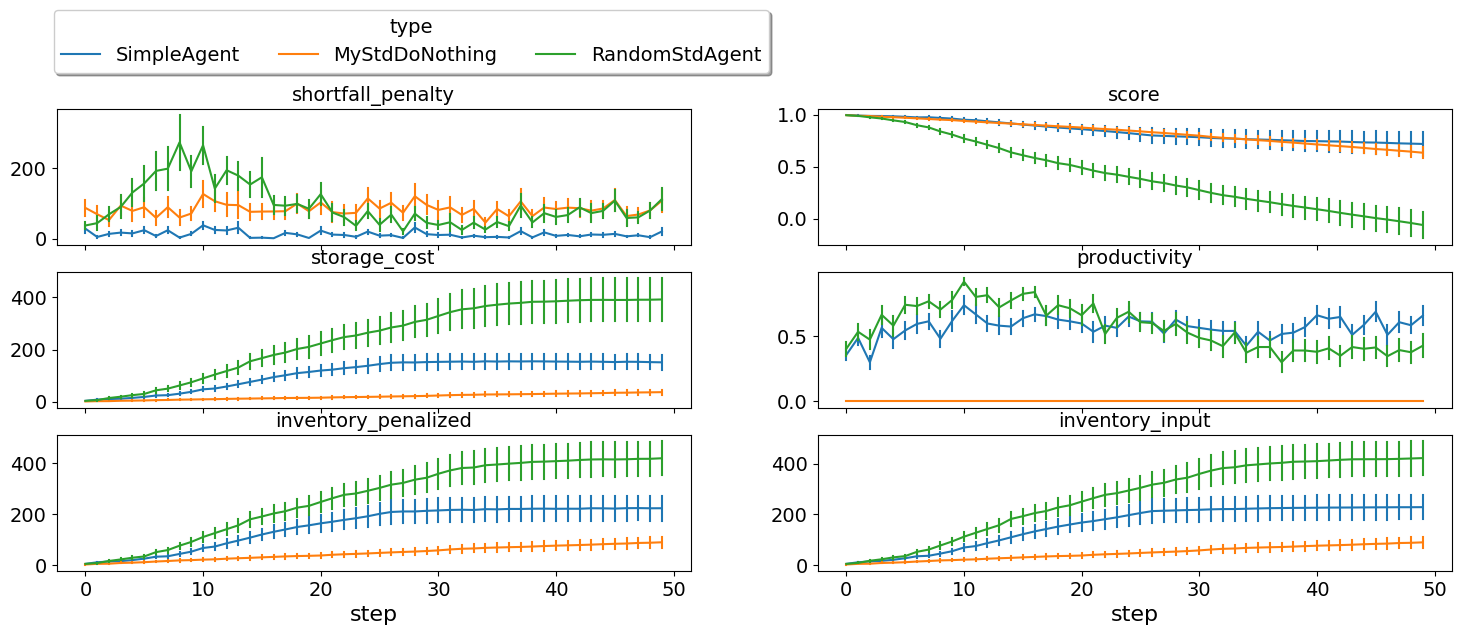

In [21]:
single_agent_runner.plot_stats(agg=False, legend_ncols=5);

This simple agent is better than the random agent. Let's understand how it works:

The main idea of this agent is pretty simple. It tries to *secure* as much of its needs (sales/supplies) as possible in every negotiation at the best possible price for itself conceding on price over time. Once today's needs are secure it tries to secure some of what expects to need in the future.


Here is the full implementation of `propose`:
```python
def propose(self, negotiator_id: str, state) -> "Outcome":
    return self.good_offer(negotiator_id)
```

The agent concedes in price and finds the best quantity to offer (and the best day to offer the delivery) in the `good_offer()` method which we will explain later.

The `respond` method is also verys simple:

```python
def respond(self, negotiator_id, state, source=""):      
    offer = state.current_offer
    return (
        ResponseType.ACCEPT_OFFER
        if self.is_needed(negotiator_id, offer)
        and self.is_good_price(negotiator_id, offer, state)
        else ResponseType.REJECT_OFFER
    )
```

It simply accepts the offer if it is *needed* and had a *good price* and rejects it otherwise. Note that this agent never ends a negotiation because it can always just keep rejecting everything but maybe a good offer will come later.

The agent needs three main subroutines: 
- `is_needed()` to decide if an offer is needed.
- `is_good_price()` to decide if the price is good given the delivery date and quantity offered.
- `good_offer()` to generate a good offer.

All of these subroutines need to know how much an agent needs to buy/sell to a given negotiator at agiven delivery date which is what `_needs()` does. We start by discecting this method:

The first step is to find our *total* needs today which depends on our location in the supply chain:

```python
if self.awi.is_first_level:
    total_needs = self.awi.needed_sales
elif self.awi.is_last_level:
    total_needs = self.awi.needed_supplies
else:
    total_needs = self.production_level * self.awi.n_lines
```

If we are in the first or last level, we can directly read our needs from the `AWI`. For agents in the middle of the supply chain, these needs will read zero as it can just do nothing. To make some profit, we set a production level (25% in this example) and assume that we always need to buy and sell enough to achieve this level of production. This what the last line above does.

This is just what we need to buy/sell today. We then need to convert that into what we are *expecting* to need by the time `t` passed to `_needs()`. This depends on whether we are negotiating with a consumer or a supplier. If it is a consumer, we need to add the *expected* production until the time `t` and then subtract whatever sales we already secured *until* `t`:

```python
total_needs += self.production_level * self.awi.n_lines * (t - self.awi.current_step)
total_needs -= self.awi.total_sales_until(t)
```

If it is a supplier, we need to add what we expect to produce *after* time `t` and subtract any supplies we secured *after* `t`:

```python
total_needs += (
    self.production_level * self.awi.n_lines * (self.awi.n_steps - t - 1)
)
total_needs -= self.awi.total_supplies_between(t, self.awi.n_steps - 1)
```

Now that we know how to calcualte the quantity we should buy/sell at any day, we can go back into our three subroutines:

`is_needed()` is the simplest as it just checks if the quantity in the offer is less than or equal the needs at the delivery date offered:

```python
return offer[QUANTITY] <= self._needs(partner, offer[TIME])
```
`is_good_price()` is also simple. We find the relative time in the negotiation (`r`). The nearer are we to the end of the negotiation, we simply accept worse prices (higher for buying and lower for selling):

```python
if self.is_consumer(partner):
    return offer[UNIT_PRICE] >= minp + (1 - r) * (maxp - minp)
return -offer[UNIT_PRICE] >= -minp + (1 - r) * (minp - maxp)
```    
Moreover, we concede less if this offer is about he future (because we can have other chances to negotiate a better deal):

```python
r = state.relative_time
if offer[TIME] > self.awi.current_step:
    r *= self.future_concession
```

Finally, we need to generate good offers in `good_offer()`. The main idea here is to always try to satisfy what we need today before tomorrow and tomorrow before the day after. That is why we loop over delivery days from now to the negotiation horizon:

```python
for t in sorted(list(issues[TIME].all)):
    ...
```

For each delivery day, we start by finding our needs using `_needs()` and offer as much of it as we can:

```python
offer[QUANTITY] = max(min(needed, qissue.max_value), qissue.min_value)
```

The only remaining issue is price. We simply concede linearly (as we did in `is_good_price()`) depending on the relative time in the negotiation (taking care to concede only to 10% of what we can for future contracts). This code is very similar to what we showed before in `is_good_price()`.


### A (suposedly) better greedy agent

One problem with our `SimpleAgent` is that it does not take its *standing offers* into account. For example, if I need 10 items and I am negotiating with 5 partners, I will offer all of them to give me these 10 items and I may end up securing 50 which will lead to penalties. The following agent tries to remedie this by just assuming that all standing offers will be accepted. This is the other extreme. In the example above, it will just offer 10 for the first partner. 

This is done in the `_needs()` method below. It starts by just getting the needs the same was as in `SimpleAgent`:

```python
n = super()._needs(partner, t)
```

but it then reduces this by whatever we currently offer after the given time `t`:

```python
n = max(0, n - v)
```

The rest of the code keeps track of our offers (`offered_sales`, `offered_supplies`) for each partner at every day.

In [22]:
from collections import defaultdict


class OptimisticAgent(SimpleAgent):
    """A greedy agent based on SimpleAgent with more sane strategy"""

    def propose(self, negotiator_id, state):
        offer = self.good_offer(negotiator_id, state)
        if offer is None:
            return offer
        offered = self._offered(negotiator_id)
        offered[negotiator_id] = {offer[TIME]: offer[QUANTITY]}
        return offer

    def before_step(self):
        self.offered_sales = defaultdict(lambda: defaultdict(int))
        self.offered_supplies = defaultdict(lambda: defaultdict(int))

    def on_negotiation_success(self, contract, mechanism):
        partner = [_ for _ in contract.partners if _ != self.id][0]
        offered = self._offered(partner)
        offered[partner] = dict()

    def _offered(self, partner):
        if self.is_consumer(partner):
            return self.offered_sales
        return self.offered_supplies

    def _needs(self, partner, t):
        n = super()._needs(partner, t)
        offered = self._offered(partner)
        for k, v in offered[partner].items():
            if k > t:
                continue
            n = max(0, n - v)
        return int(n)

In [23]:
single_agent_runner(OptimisticAgent);

Let's see how well did this agent behave:

In [24]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
3,SimpleAgent,0.718652,30.0,0.718652,0.626017,-0.840914,0.827423,0.999168,1.043844,1.212995
1,OptimisticAgent,0.715633,30.0,0.715633,0.595175,-0.833523,0.806630,0.972029,1.036741,1.183959
0,MyStdDoNothing,0.634120,30.0,0.634120,0.303902,0.123079,0.504789,0.704111,0.878543,1.000000
2,RandomStdAgent,-0.061693,30.0,-0.061693,0.708594,-1.504509,-0.510917,-0.183504,0.474423,0.981504


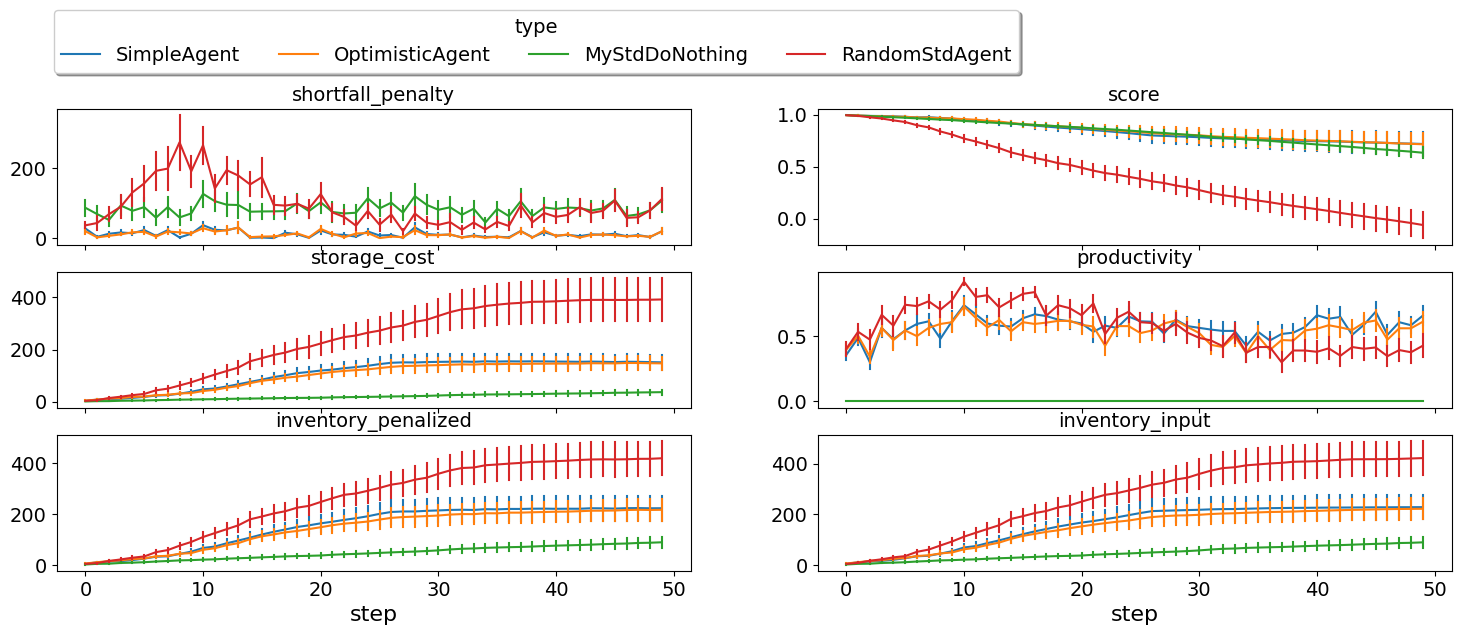

In [25]:
single_agent_runner.plot_stats(agg=False, legend_ncols=4);

It seems that `OptimitisticAgent` is getting a higher score compared with `SimpleAgent`. Of course this is only guaranteed in the given configs. Note that `OptimisticAgent` is kind of *over* optimistic as it counts anything it offers as if it was *accepted*. A balance is needed. Maybe you can find a better wat to achieve this balance. Moreover, the decision to just count any standing offer in the future when deciding needs is kind of arbitrary. We can do better.

### Simple Sync Agent

One problem that plagued all of our agents so far is that they have to make decisions (`respond`, `propose`) about negotiations **on the spot**. This makes it difficult to consider **all other negotiations** while making decisions. 

Because the utility function is defined for **a complete set of negotiation agreements** and not for any single negotiation by itself, it makes sense to try to make decisions **centrally** by collecting offers from partners then responding to all of them at once. It is possible to do that by utilizing the response type ```ResponseType.WAIT``` supported by NegMAS but this entails a lot of house-keeping. 

To simplify this task, we provide another base class for agents that does all of this house keeping for you exposing a simple interface that **syncrhonizes** all negotiations (as much as allowed by the underlying platform). The main goal of this base agent is to allow the developer to think about *all negotiations together* but it has some important caveats which we will discuss later.
Here is an example of writing the do-nothing agent in this form:

In [26]:
class MySyncOneShotDoNothing(StdSyncAgent):
    """My Agent that does nothing"""

    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        return dict()

    def first_proposals(self):
        """Decide a first proposal on every negotiation.
        Returning None for a negotiation means ending it."""
        return dict()

In [ ]:
single_agent_runner(MySyncOneShotDoNothing);

In [ ]:
single_agent_runner.score_summary()

As you can see, in this case, we need to override `counter_all` to counter offers received from *all* the partners and `first_proposals` to decide a first offer for *each* partner. 

Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `counter_all` and `first_proposals` are optional.

In [ ]:
class SimpleSyncAgent(StdSyncAgent, SimpleAgent):
    """An agent that distributes its needs over its partners randomly."""

    def first_proposals(self):
        """Decide a first proposal on every negotiation.
        Returning None for a negotiation means ending it."""
        return {
            partner: SAOResponse(
                ResponseType.REJECT_OFFER, SimpleAgent.propose(self, partner, state)
            )
            for partner, state in self.awi.current_states.items()
        }

    def counter_all(self, offers, states) -> dict:
        """Respond to a set of offers given the negotiation state of each."""
        # find all responses
        responses = {k: SimpleAgent.respond(self, k, s) for k, s in states.items()}
        # find counter offers for rejected offers
        myoffers = {
            k: SimpleAgent.propose(self, k, s)
            for k, s in states.items()
            if responses[k] == ResponseType.REJECT_OFFER
        }
        # compile final responses
        return {
            k: SAOResponse(
                responses[k],
                myoffers.get(
                    k, offers[k] if responses[k] == ResponseType.ACCEPT_OFFER else None
                ),
            )
            for k in states.keys()
        }

    # needed for the way multiple inheritence work in python.
    # we only need these because we inherit from `SimpleAgent`.
    # future agents will not need these two functions.
    def propose(self, negotiator_id, state):
        return StdSyncAgent.propose(self, negotiator_id, state)

    def respond(self, negotiator_id, state, source=""):
        return StdSyncAgent.respond(self, negotiator_id, state, source)

In [ ]:
single_agent_runner(SimpleSyncAgent);

In [ ]:
single_agent_runner.score_summary()

In [ ]:
single_agent_runner.plot_stats(agg=False, legend_ncols=3, ylegend=2);

This agent behaves exactly the same as `BetterAgent`. We simply just call `propose()` and `respond()` from `BetterAgent` **independently** for each negotiator and do not really use the fact that we have access to all the offers and can respond to all of them centrally now.

### A better SyncAgent

We start by defining a simple helper function that distributes a given quantity $q$ over $n$ partners.

In [ ]:
def distribute(q: int, n: int) -> list[int]:
    """Distributes n values over m bins with at least one item per bin assuming q > n"""
    from numpy.random import choice
    from collections import Counter

    if q < n:
        lst = [0] * (n - q) + [1] * q
        random.shuffle(lst)
        return lst

    if q == n:
        return [1] * n
    r = Counter(choice(n, q - n))
    return [r.get(_, 0) + 1 for _ in range(n)]

Here are few examples of how it would distribute $10$ units over $4$ partners

In [ ]:
[distribute(10, 4) for _ in range(5)]

In [ ]:
[distribute(2, 4) for _ in range(5)]

We will also need a helper function to find all subsets of a given set (powerset):

In [ ]:
from itertools import chain, combinations, repeat


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

Now we can define our new agent:

In [ ]:
class ProactiveAgent(SimpleSyncAgent):
    """An agent that distributes today's needs randomly over 75% of its partners and
    samples future offers randomly."""

    def __init__(self, *args, threshold=None, ptoday=0.75, productivity=0.6, **kwargs):
        super().__init__(*args, **kwargs)
        if threshold is None:
            threshold = random.random() * 0.2 + 0.2
        self._threshold = threshold
        self._ptoday = ptoday
        self._productivity = productivity

    def first_proposals(self):
        # just randomly distribute my needs over my partners (with best price for me).
        partners = self.negotiators.keys()
        s = self.awi.current_step
        distribution = self.distribute_todays_needs()
        return {
            k: (q, s, self.best_price(k))
            if q > 0
            else self.sample_future_offer(k).outcome
            for k, q in distribution.items()
        }

    def counter_all(self, offers, states):
        response = dict()
        # process for sales and supplies independently
        for edge_needs, all_partners, issues in [
            (
                self.awi.needed_supplies,
                self.awi.my_suppliers,
                self.awi.current_input_issues,
            ),
            (
                self.awi.needed_sales,
                self.awi.my_consumers,
                self.awi.current_output_issues,
            ),
        ]:
            # correct needs if I am in the middle
            needs = (
                max(edge_needs, int(self.awi.n_lines * self._productivity))
                if self.awi.is_middle_level
                else edge_needs
            )

            # find active partners
            partners = {_ for _ in all_partners if _ in offers.keys()}

            # find the set of partners that gave me the best offer set
            # (i.e. total quantity nearest to my needs)
            plist = list(powerset(partners))
            best_diff, best_indx = float("inf"), -1
            for i, partner_ids in enumerate(plist):
                others = partners.difference(partner_ids)
                offered = sum(offers[p][QUANTITY] for p in partner_ids)
                diff = abs(offered - needs)
                if diff < best_diff:
                    best_diff, best_indx = diff, i
                if diff == 0:
                    break

            # If the best combination of offers is good enough, accept them and end all
            # other negotiations
            if best_diff <= self._threshold:
                partner_ids = plist[best_indx]
                others = list(partners.difference(partner_ids))
                response.update(
                    {
                        k: SAOResponse(ResponseType.ACCEPT_OFFER, offers[k])
                        for k in partner_ids
                    }
                    | {k: self.sample_future_offer(k) for k in others}
                )
                continue

            # If I still do not have a good enough offer, distribute my current needs
            # randomly over my partners.
            distribution = self.distribute_todays_needs()
            response |= {
                k: self.sample_future_offer(k)
                if q == 0
                else SAOResponse(
                    ResponseType.REJECT_OFFER, (q, self.awi.current_step, self.price(k))
                )
                for k, q in distribution.items()
            }
        return response

    def distribute_todays_needs(self, partners=None) -> dict[str, int]:
        """Distributes my urgent (today's) needs randomly over some my partners"""
        if partners is None:
            partners = self.negotiators.keys()

        # initialize all quantities to zero
        response = dict(zip(partners, repeat(0)))
        # repeat for supplies and sales
        for is_partner, edge_needs in (
            (self.is_supplier, self.awi.needed_supplies),
            (self.is_consumer, self.awi.needed_sales),
        ):
            # get my current needs
            needs = (
                max(edge_needs, int(self.awi.n_lines * self._productivity))
                if self.awi.is_middle_level
                else edge_needs
            )
            #  Select a subset of my partners
            active_partners = [_ for _ in partners if is_partner(_)]
            if not active_partners or needs < 1:
                continue
            random.shuffle(active_partners)
            active_partners = active_partners[
                : max(1, int(self._ptoday * len(active_partners)))
            ]
            n_partners = len(active_partners)

            # if I need nothing or have no partnrs, just continue
            if needs <= 0 or n_partners <= 0:
                continue

            # If my needs are small, use a subset of negotiators
            if needs < n_partners:
                active_partners = random.sample(
                    active_partners, random.randint(1, needs)
                )
                n_partners = len(active_partners)

            # distribute my needs over my (remaining) partners.
            response |= dict(zip(active_partners, distribute(needs, n_partners)))

        return response

    def sample_future_offer(self, partner):
        # get a random future offer. In reality an offer today may be returned
        nmi = self.get_nmi(partner)
        outcome = nmi.random_outcome()
        t = outcome[TIME]
        if t == self.awi.current_step:
            mn = max(nmi.issues[TIME].min_value, self.awi.current_step + 1)
            mx = max(nmi.issues[TIME].max_value, self.awi.current_step + 1)
            if mx <= mn:
                return SAOResponse(ResponseType.END_NEGOTITAION, None)
            t = random.randint(mn, mx)
        return SAOResponse(
            ResponseType.REJECT_OFFER, (outcome[QUANTITY], t, self.best_price(partner))
        )

    def is_supplier(self, partner):
        return partner in self.awi.my_suppliers

    def best_price(self, partner):
        issue = self.get_nmi(partner).issues[UNIT_PRICE]
        pmin, pmax = issue.min_value, issue.max_value
        return pmin if self.is_supplier(partner) else pmax

    def price(self, partner):
        return self.get_nmi(partner).issues[UNIT_PRICE].rand()

As usual for agents based on [SyncStdAgent](https://scml.readthedocs.io/en/latest/autoapi/scml/std/agent/index.html#scml.std.agent.StdSyncAgent), we need to define `first_offers()` and `counter_all()`

#### Generating First Offers

We simply distribute our needs for today over as many partners as possible and send random offers (at our best price) for the remaining partners. This is achieved in two steps. Firstly, we distribute our needs *for today* over all our partners using:

```python
distribution = self.distribute_todays_needs()
```

If some of our partners are not needed (i.e. has zero quantity in `distribution`), we sample random outcomes for them:

```python
return {
    k: (q, s, self.best_price(k)) 
    if q > 0 else 
    self.sample_future_offer(k).outcome
    for k, q in distribution.items()
}
```

Note that we always use our *best price* for all offers.

We will describe how do we `distribute_todays_needs` and `sample_future_offer` later after we describe counter offering.

#### Generating counter offers

This process is more involved. The main idea is to process supplies and sales separately. For each, we find a subset of partners to distribute today's needs between them and then sample random offers for the rest (that will likely have future delivery dates). For all offers, we just use random prices. Now, we describe this process in details:


The way we handle sales and supplies separately is to loop over them separately getting the amount we need, names of partners and negotiation issues from our AWI:

```python
for edge_needs, all_partners, issues in [
    (self.awi.needed_supplies,self.awi.my_suppliers,self.awi.current_input_issues),
    (self.awi.needed_sales,self.awi.my_consumers,self.awi.current_output_issues),
]:
    ...
```    

The needs we get here `edge_needs` will not be accurate if we are in the middle of the production graph because if we have no contracts we will just get zero for both sides. We correct this by just assuming some production level and use it if `edge_needs` was too small:

```python
needs = int(
    max(edge_needs, int(self.awi.n_lines * self._productivity))
    if self.awi.is_middle_level
    else edge_needs
)
```

We then get a random price and find the partners we are still negotiating with
```python
partners = {_ for _ in all_partners if _ in offers.keys()}
```

We then consider all subsets of of offers from our partners and find out the one that gives us best match to our needs. Note that we do not consider prices at all here.

```python
plist = list(powerset(partners))
best_diff, best_indx = float("inf"), -1
for i, partner_ids in enumerate(plist):
    others = partners.difference(partner_ids)
    offered = sum(offers[p][QUANTITY] for p in partner_ids)
    diff = abs(offered - needs)
    if diff < best_diff:
        best_diff, best_indx = diff, i
    if diff == 0:
        break
```

If the mismatch in quantity we just caculated is good enough (i.e. less than some predefined threshold), we accept the subset of offers that generated this best match and just sample random quantities and delivery dates for others but at our best price (using `sample_future_offer`).

```python
if best_diff <= self._threshold:
    partner_ids = plist[best_indx]
    others = list(partners.difference(partner_ids))
    response.update(
        {
            k: SAOResponse(ResponseType.ACCEPT_OFFER, offers[k])
            for k in partner_ids
        } | {k: self.sample_future_offer(k) for k in others}
    )
    continue
```

If we did not accept any subset of offers, we simply distribute today's needs over our partners while submitting random counter offers (at best price) to any partners we happen to assign zero quantity. This is exactly the same as we did in `first_proposals` except that we use a random price for today's offers.

```python
distribution = self.distribute_todays_needs()
response |= {
    k: SAOResponse(ResponseType.REJECT_OFFER, self.sample_future_offer(k))
    if q == 0
    else SAOResponse(
        ResponseType.REJECT_OFFER, (q, self.awi.current_step, self.price(k))
    )
    for k, q in distribution.items()
}
```

To complete our understanding, we need to clarify the process by which we distribute today's needs and sample future offers.

#### Distributing Today's Needs

As usual, we process sales and supplies independently:

```python
for is_partner, edge_needs in (
    (self.is_supplier, self.awi.needed_supplies),
    (self.is_consumer, self.awi.needed_sales),
):
    ...
```

We correct the need for the case of being in the middle of the production graph. 

```python
needs = (
    max(edge_needs, int(self.awi.n_lines * self._productivity))
    if self.awi.is_middle_level
    else edge_needs
)
```

We then get the suppliers if we are considering supplies and consumers if we are considering sales. After that, we sample randomly a predefined fraction of them.

```python
active_partners = [_ for _ in partners if is_partner(_)]
if not active_partners or needs < 1:
    continue
random.shuffle(active_partners)
active_partners = active_partners[
    : max(1, int(self._ptoday * len(active_partners)))
]
n_partners = len(active_partners)
```

If we do not need anything or there are no partners, we just go to the next group of partners (if any).

```python
if needs <= 0 or n_partners <= 0:
    continue
```

If our needs are relativey small, we concentrate them in a smaller number of partners to keep more of them for future offers.

```python
if needs < n_partners:
    active_partners = random.sample(
        active_partners, random.randint(1, needs)
    )
    n_partners = len(active_partners)
```

Finally, we distribute today's needs over these partners

```python
response |= dict(zip(active_partners, distribute(needs, n_partners)))
```

#### Sampling future needs

We simply sample a random outcome

```python
nmi = self.get_nmi(partner)
outcome = nmi.random_outcome()
```

Note that there is a possiblity that the delivery day here may be today but we want to be sure that the offer is in the future. To achieve that, we check for this condition and sample a new time in the future. If no such time can be found (e.g. in the very last step of the negotiation), simply end the negotiation.

```python
t = outcome[TIME]
if t == self.awi.current_step:
    mn = max(nmi.issues[TIME].min_value, self.awi.current_step + 1)
    mx = max(nmi.issues[TIME].max_value, self.awi.current_step + 1)
    if mx <= mn:
        return SAOResponse(ResponseType.END_NEGOTITAION, None)
    t = random.randint(mn, mx)
```

Now that we have a time in the future, we counter with an offer with the sampled quantity, time and best price.

```python
return SAOResponse(
    ResponseType.REJECT_OFFER,
    (outcome[QUANTITY], t, self.best_price(partner))
)
```

Let's see how does this agent fair against others we developed so far:

In [ ]:
single_agent_runner(ProactiveAgent);

In [ ]:
single_agent_runner.score_summary()

In [ ]:
single_agent_runner.plot_stats(agg=False, legend_ncols=5, ylegend=2);

These results show that `ProactiveAgent` is much better than the `SimpleSyncAgent` which did not really consider all offers together. Nevertheless, it is not as good as `OptimisticAgent` or `SimpleAgent`. Specifically, we can see that it gets higher storage cost which means that it seems to carry more inventory that it does not need.

#### Possible Improvements

There are obvious ways to improve this agent:

1. We are using random prices for today's needs (`price()`). May be, we can concede on price as we did in `SimpleAgent`.
1. We are *always* using our best price for future offers. May be, we can concede in price here but not as much as for today's needs.
1. When countering offers, we should take into account the history of negotiation with each partner (in this round and previously) to make a more meaningful distribution of quantities over partners. Currently this is just random. We should also consider the probability that our offers will be accepted when deciding how to distribute the quantity we still need over our partners.
1. Choosing which negotiators to end the negotiation with when we need a small quantity to buy/sell, is currently random. We could try to find a way to only end negotiation with negotiators least likely to provide us with our remaining needs.
1. We should take the number of rounds remiaining in the negotiation into account when deciding whether to accept a subset of offers (e.g. have a higher threshold near the end of the negotiation), and when deciding what quantities to distribute over our partners (e.g. offer more than what we need near the end of the negotiation under the assumption that only some of them will be accepted).
1. May be consider prices more when approaching our total needs.

### Comparing all agents

We can now look at all the agents we considered so far:

In [ ]:
single_agent_runner.plot_stats(notch=True);

Let's also add a couple of the built-in agents to the mix and see where do these fit:

In [ ]:
for t in (GreedyStdAgent, SyncRandomStdAgent):
    single_agent_runner(t)

In [ ]:
single_agent_runner.plot_stats(notch=True, stats="score");

As you can see, `GreedyStdAgent` and `SyncRandomStdAgent` are getting good scores but not better than the simple agents we developed in these tutorials.

In [ ]:
single_agent_runner.score_summary()

Out of curiosity, let's compare these agents when each is allowed to control the whole market:

In [ ]:
FMR = WorldRunner.from_runner(single_agent_runner, control_all_agents=True)
for t in (
    SimpleSyncAgent,
    MyStdDoNothing,
    MySyncOneShotDoNothing,
    SimpleAgent,
    OptimisticAgent,
    RandomStdAgent,
    ProactiveAgent,
    GreedyStdAgent,
    SyncRandomStdAgent,
):
    FMR(t)

In [ ]:
FMR.plot_stats(notch=True, stats="score");

In [ ]:
FMR.score_summary()

As is clear when comparing the last two tables, the relative order (specially between the best scoreing agents) is dependent on the how many agents they are allowed to control in the market. In the SCML ANAC competition, we are always assuming that the evaluated agent type can control a single agent in the market. It is interesting to note that all agents lost money on average when allowed to control the whole market (and almost all of them if we consider median score). 

The way we just compared these agents is  unbiased because all agents are allowed to control the same factories in the same simulation envoironment. Nevertheless, the way we evaluate agents in the official ANAC competition uses upper truncated mean not the mean nor the median when scoring agents. The best way to compare these agents in exactly the same was as in the competition is to run a tournament between them. You already learned how to do that in the previous tutorial and we will not repeate it here.

*If you are running this notebook, please note that the tournament running methods `anac2023_*` may not work within a notebook environment. You can just move your code to a normal python script and it will run correctly*


You can find all the agents available in the `scml` package for the one-shot game under `scml.oneshot.agents` including the ones developed in this tutorial (with some modifications):

In [ ]:
import scml.std.agents as agents

print([_ for _ in agents.__dir__() if _.endswith("Agent")])